In [1]:
import os
import json
import pandas as pd
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from datetime import datetime as dt

In [2]:
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

# Load Data

In [24]:
DATASET = 'winogrande-m-option'
wd = os.path.dirname(os.path.abspath('__file__'))
f_name1 = f"{DATASET}_1.csv"
f_name2 = f"{DATASET}_2.csv"

results1 = pd.read_csv(os.path.join(wd, f_name1))
results2 = pd.read_csv(os.path.join(wd, f_name2))


results = pd.concat([results1,results2]).reset_index()
results = results.loc[results['dataset']==DATASET,:]

In [25]:
print(results)
print(results['best_val_accuracy'])

     index              dataset        framing  learning_rate  batch_size  \
121    121  winogrande-m-option         MC-MLM        0.00001          16   
122    122  winogrande-m-option         MC-MLM        0.00001          16   
123    123  winogrande-m-option         MC-MLM        0.00001          64   
124    124  winogrande-m-option         MC-MLM        0.00002          32   
125    125  winogrande-m-option         MC-MLM        0.00002          32   
..     ...                  ...            ...            ...         ...   
536    205  winogrande-m-option         P-SENT        0.00003          16   
537    206  winogrande-m-option         P-SENT        0.00002          16   
538    207  winogrande-m-option         P-SENT        0.00003          32   
539    208  winogrande-m-option         P-SENT        0.00003          32   
540    209  winogrande-m-option  MC-SENT-PLOSS        0.00002           8   

     max_epochs    seed  best_val_accuracy  \
121          20  810635      

In [26]:
print(len(results['exp_name'].unique()))

420


# Analyze

In [5]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

In [71]:
def make_box_plots(data,
                   labels,
                   experiment_labels, 
                   key_frame = 'framing',
                   key_acc = 'best_val_accuracy',
                   x_size = 15,
                   y_size = 5,
                   y_min = 55,
                   y_max = 100,
                   y_tick = 15,
                   y_offset = 1,
                   x_offset = .85,
                   splines_offset = 10,
                   bar_trans = 0.3,
                   colors = ['darkgrey',
                             'peachpuff',
                             'burlywood',
                             'gold',
                             'lightgreen',
                             'skyblue',
                             'plum',
                             'darkgrey'
                            ],
                   bar_colors = True,
                   bar_labels = True,
                   adjusted_axes = True,
                   title = None,
                   showfliers = True,
                   notch = False,
                   majority = None,
                   human = None,
                   ylabel = 'Accuracy (%)',
                   xlabel = 'Formalization',
                   label_size = 18,
                   tick_size = 12,
                   plabel_size = 12,
                   bar = False,
                   label_type = 'max',
                   box = True,
                   violin = False,
                   titlepad=None,
                   titleh=None,
                  ):    
    scores = {
        'all'    : [],
        'max'    : [],
        '3Q'     : [],
        'median' : [],
    }
    
    add_x_offset = {
        'max'    : 0,
        '3Q'     : 0.4,
        'median' : 0.45,
    }
    
    add_y_offset = {
        'max'    : 0,
        '3Q'     : -y_offset,
        'median' : -y_offset,
    }  
        
    for label in experiment_labels:
        dist = data.loc[data[key_frame]==label,key_acc]*100
        scores['all'].append(sorted(dist.to_numpy()))
        scores['max'].append(max(dist))
        scores['3Q'].append(dist.quantile(q=0.75))
        scores['median'].append(dist.median())
    
    n_samples = len(scores['all'][0])
    
    # add majority class
    if not majority is None:
        labels.insert(0,'Majority')
        if bar:
            scores['all'].insert(0,[0])
        else:
            scores['all'].insert(0,[majority]*n_samples)
        
        for key, item in scores.items():
            if key != 'all':
                item.insert(0,majority)
    
    # add human results
    if not human is None:
        labels.append('Human')
        if bar:
            scores['all'].append([0])
        else:
            scores['all'].append([human]*n_samples)

        for key, item in scores.items():
            if key != 'all':
                item.append(human)
    
    
    # create figure
    fig, ax = plt.subplots(figsize=(x_size, y_size))
    
    # format chart
    if not title is None:
#         ax.set_title(title, fontsize=label_size, pad=titlepad)
        ax.text(len(labels)/2+0.5,
                titleh,
                title,
                fontsize=label_size,
                ha="center",
                )
    
    # format labels
    ax.set_ylim(y_min, y_max)
    ax.set_yticks(np.arange(y_min, y_max+1, y_tick))
    ax.set_xticklabels(labels)
    ax.tick_params(labelsize=tick_size)
    
    if adjusted_axes:
        # Adjust plot borders
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_position(('outward', splines_offset))
        ax.spines['bottom'].set_position(('outward', splines_offset))
    
    ticks = np.arange(len(labels))+1
    
    ax.set_ylabel(ylabel, fontsize=label_size)
    ax.set_xlabel(xlabel, fontsize=label_size)
    
    # make plots    
    assert label_type in scores.keys(), f"label_type {label_type} not supported"
    
    if bar:
        # bar chart
        if not bar_colors:
            colors = None
        ax.bar(ticks, scores[label_type], color = colors, alpha=bar_trans)
        
    if box:
        # box plot
        ax.boxplot(scores['all'], notch = notch, showfliers = showfliers)
        
    if violin:
        # violin plot
        ax.set_xticks(ticks)
        
        parts = ax.violinplot(scores['all'], positions = ticks, showmedians = False, showextrema=False, bw_method='silverman')
        
        if bar_colors:
            for pc, color in zip(parts['bodies'], colors):
                pc.set_facecolor(color)
                pc.set_alpha(.5)
                pc.set_edgecolor('black')

        quartile1, medians, quartile3 = np.percentile(scores['all'], [25, 50, 75], axis=1)
        whiskers = np.array([
            adjacent_values(sorted_array, q1, q3)
            for sorted_array, q1, q3 in zip(scores['all'], quartile1, quartile3)])
        whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]

        inds = np.arange(1, len(medians) + 1)
        ax.scatter(inds[1:len(inds)-1], medians[1:len(inds)-1], marker='_', color='orange', s=1000, zorder=3)
        ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
        ax.vlines(inds, whiskersMin, whiskersMax, color='k', linestyle='-', lw=1)
                
    
    # add accuracy values
    for i, v in enumerate(scores[label_type]):
        if bar_labels or (i==0 or i==len(scores[label_type])-1):
            
            x=add_x_offset[label_type]
            y=add_y_offset[label_type]
            
            if ((not human is None and i == len(scores[label_type])-1)
                or (not majority is None and i == 0)):
                x = 0
                y = 0
                
            ax.text(i + x_offset + x,
                    v + y_offset + y,
                    "{:.1f}%".format(v),
                    fontsize=plabel_size,
                   )
    
    # Adjust layout
    fig.tight_layout()
    
    return fig

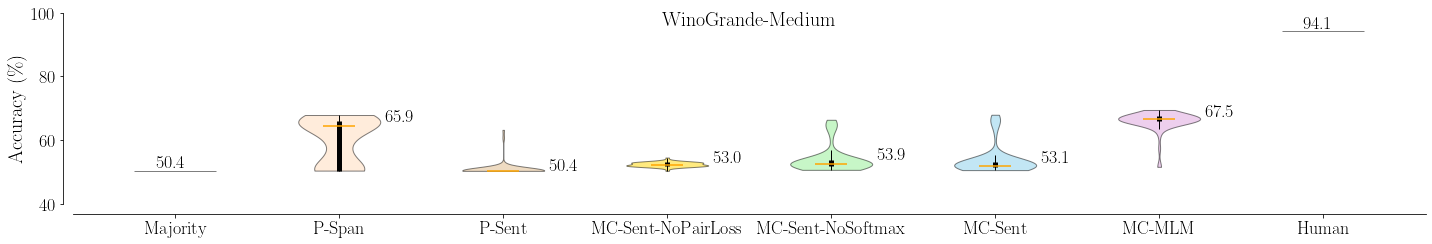

In [80]:
bar = False
box = False
violin = True

ordered_framings = ['P-SPAN',
                   'P-SENT',
                   'MC-SENT-PLOSS',
                   'MC-SENT-PAIR',
                   'MC-SENT',
                   'MC-MLM']

chart_labels = ['P-Span',
               'P-Sent',
               'MC-Sent-NoPairLoss',
               'MC-Sent-NoSoftmax',
               'MC-Sent',
               'MC-MLM']

f_violin = make_box_plots(results,
                   chart_labels,
                   ordered_framings,
                   adjusted_axes = True,
                   title = 'WinoGrande-Medium',
                   titleh=96,
                   showfliers = True,
                   x_size = 20,
                   y_size = 3.5,
                   y_min = 40,
                   y_max = 100,
                   y_tick = 20,
                   notch = False,
                   ylabel = r'Accuracy (\%)',
                   xlabel = None,
                   #xlabel = r'Formalization',
                   majority = 50.43,
                   human = 94.1,
                   label_size=20,
                   tick_size=18,
                   plabel_size=18,
                   x_offset = .88,
                   bar_colors = True,
                   bar_labels = True,
                   label_type = '3Q',
                   bar = bar,
                   box = box,
                   violin = violin,
                  )

In [50]:
def get_stats(data,
              labels,
              key_frame = 'framing',
              key_acc = 'best_val_accuracy',
             ):
    results = {label : {} for label in labels}
    
    for label, value in results.items():
        dist = data.loc[data[key_frame]==label,key_acc]
        
        value['mean'] = dist.mean()
        value['std'] = dist.std()
        value['medium'] = dist.median()
        value['1Q'] = dist.quantile(q=0.25)
        value['3Q'] = dist.quantile(q=0.75)
        value['max'] = max(dist)
        value['min'] = min(dist)
        value['top_3Q_dist'] = max(dist)-dist.quantile(q=0.75)
        value['kurtosis'] = dist.kurtosis()
    
    return results

In [51]:
ordered_framings = ['P-SPAN',
                   'P-SENT',
                   'MC-SENT-PLOSS',
                   'MC-SENT-PAIR',
                   'MC-SENT',
                   'MC-MLM']

stats = get_stats(results,
                  ordered_framings,
                 )

print(stats)

{'P-SPAN': {'mean': 0.6010523546557619, 'std': 0.07029034616035999, 'medium': 0.6432517758955049, '1Q': 0.5043409629280208, '3Q': 0.6592344120380064, 'max': 0.6787687451141315, 'min': 0.5043409629, 'top_3Q_dist': 0.019534333076125177, 'kurtosis': -1.615641100770949}, 'P-SENT': {'mean': 0.5090370955090537, 'std': 0.021061960206107552, 'medium': 0.5043409629280208, '1Q': 0.5043409629, '3Q': 0.5043409629280208, 'max': 0.6322020521, 'min': 0.5035516969453846, 'top_3Q_dist': 0.12786108917197925, 'kurtosis': 27.55161348189248}, 'MC-SENT-PLOSS': {'mean': 0.5242962378353363, 'std': 0.0071131848072470034, 'medium': 0.5232833464938832, '1Q': 0.5197316495953062, '3Q': 0.5297947908719246, 'max': 0.5453827940251005, 'min': 0.5035516969, 'top_3Q_dist': 0.015588003153175878, 'kurtosis': 0.7239932749745304}, 'MC-SENT-PAIR': {'mean': 0.5410812944087854, 'std': 0.0419394712962352, 'medium': 0.5256511444591968, '1Q': 0.5193370166, '3Q': 0.5386740331807813, 'max': 0.6637726914000001, 'min': 0.5067087609, 

In [52]:
stats_df = pd.DataFrame(stats)

print(stats_df)

               P-SPAN     P-SENT  MC-SENT-PLOSS  MC-SENT-PAIR   MC-SENT  \
mean         0.601052   0.509037       0.524296      0.541081  0.537793   
std          0.070290   0.021062       0.007113      0.041939  0.045439   
medium       0.643252   0.504341       0.523283      0.525651  0.520126   
1Q           0.504341   0.504341       0.519732      0.519337  0.515391   
3Q           0.659234   0.504341       0.529795      0.538674  0.531176   
max          0.678769   0.632202       0.545383      0.663773  0.679558   
min          0.504341   0.503552       0.503552      0.506709  0.505919   
top_3Q_dist  0.019534   0.127861       0.015588      0.125099  0.148382   
kurtosis    -1.615641  27.551613       0.723993      2.974123  4.090518   

                MC-MLM  
mean          0.660471  
std           0.032389  
medium        0.666140  
1Q            0.659037  
3Q            0.675414  
max           0.694554  
min           0.516180  
top_3Q_dist   0.019140  
kurtosis     12.718074  

# Save Stuff

In [81]:
wd = os.path.dirname(os.path.abspath('__file__'))
now = dt.now().strftime("%Y%m%d_%H%M")

f = f_violin
f_type = 'violin'

plot_name = os.path.join(wd, 'plots', f"{DATASET}_plot_{f_type}_{now}.pdf")
stats_name = os.path.join(wd, 'stats', f"{DATASET}_stats_{now}.json")

f.savefig(plot_name)
with open(stats_name, 'w') as f:
    f.write(json.dumps(stats))